# Description
The first part is focused on inferring the missing value about skin color rating using machine learning algorithm. The second part try to infer wether referees' behavior change depending of the skin-color of the player.

Let start by doing some imports.

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt                         # Matplotlib's pyplot: MATLAB-like syntax
import seaborn as sns                                   # For pretty plots

## Skin-color inferring
First, let have a look to [mathewzila's suggestion](https://github.com/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) where the dataset is a disaggregate version of `data/CrowdstormingDataJuly1st.csv`. By _disaggregate_, we means that there is one observation per game between a player and a referee (in place of one observation per dyad).

Depending of the computations, this dataset might be a better option. Both will be imported in order to do some comparison.

In [2]:
df = pd.read_csv(os.path.join('data', 'CrowdstormingDataJuly1st.csv'))
print(df.head(10))

          playerShort              player               club leagueCountry  \
0       lucas-wilchez       Lucas Wilchez      Real Zaragoza         Spain   
1          john-utaka          John Utaka    Montpellier HSC        France   
2         abdon-prats         Abdón Prats       RCD Mallorca         Spain   
3          pablo-mari          Pablo Marí       RCD Mallorca         Spain   
4          ruben-pena          Rubén Peña    Real Valladolid         Spain   
5        aaron-hughes        Aaron Hughes          Fulham FC       England   
6  aleksandar-kolarov  Aleksandar Kolarov    Manchester City       England   
7    alexander-tettey    Alexander Tettey       Norwich City       England   
8   anders-lindegaard   Anders Lindegaard  Manchester United       England   
9        andreas-beck        Andreas Beck    1899 Hoffenheim       Germany   

     birthday  height  weight              position  games  victories  \
0  31.08.1983   177.0    72.0  Attacking Midfielder      1          

In [3]:
dfd = pd.read_csv(os.path.join('data', 'crowdstorm_disaggregated.csv'))
dfd.head(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone,allreds,allredsStrict,refCount
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375,0,0,1
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750,0,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,0,0,30
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,0,0,30
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,0,0,30
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250,0,0,30
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,0,0,30


In [4]:
df_cols = set(df.columns)
dfd_cols = set(dfd.columns)

print("Number of lost columns: {}".format(len(df_cols - dfd_cols)))

Number of lost columns: 0


As we can see, the deaggregated dataset doesn't remove any columns from the base data set.

In [5]:
print("New columns: {}".format(dfd_cols - df_cols))

New columns: {'skintone', 'allredsStrict', 'allreds', 'refCount'}


As we can see, new columns are created. Based on [source code](https://osf.io/w7tds/),

- allredsStrict: If player has received a red without a yellow
- allreds: If player has received a red during this game (either because he had a yellow one before, or if he's directly received a red)
- skintone: Average of rater1 and rater2 for this player
- refCount: Number of dyads per referee (thus, how many player the referee is linked to)

All are indicator variable (either 1 if true, 0 o.w.)

**Remark**: the field `games` (i.e. count the number of match between the player and the referee) is redundant on `dfd`, since there is one observation per game.

In [6]:
print("All fields: {}".format(dfd.columns))

All fields: Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp', 'skintone', 'allreds', 'allredsStrict',
       'refCount'],
      dtype='object')


Let add a `skintone` field to the aggregated version of the data

In [7]:
df['skintone'] = 0.5 * (df['rater1']+df['rater2'])
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN


### Look on skintone
As mentioned before, `skintone` is the mean between the two skin-color ratings

In [8]:
df_skinton = df[["playerShort", "skintone"]].reset_index().groupby('playerShort', axis=0).mean()
mean_skin = set(df_skinton['skintone'].dropna().unique().tolist())

unique_skin = set(df['skintone'].dropna().unique().tolist())

print("Values not in both: {}".format(mean_skin.symmetric_difference(unique_skin)))


Values not in both: set()


One error in the dataset might have been to have several different `skintone` value for the same user. As the previous code suggests, the mean of the `skintone` over a player doesn't create new value (suggesting that all the `skintone` for a player are the same).

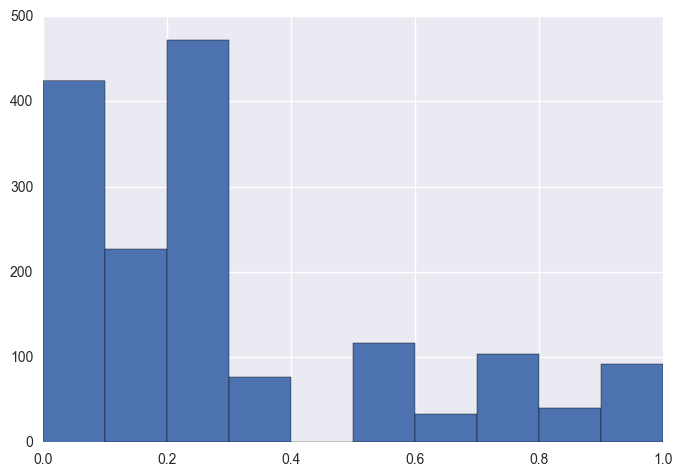

In [9]:
df_skinton['skintone'].dropna().hist()

As we can see, there are more players with a white skin than with a dark one. This need to be taken into consideration for the analysis.

### Information about players

In [10]:
referee_per_player = df.groupby('playerShort').count()['player']
referee_per_player.describe()

count    2053.000000
mean       71.129079
std        36.171246
min         1.000000
25%        45.000000
50%        67.000000
75%        92.000000
max       202.000000
Name: player, dtype: float64

We can see that player have played with a lot of different referee, in general. 

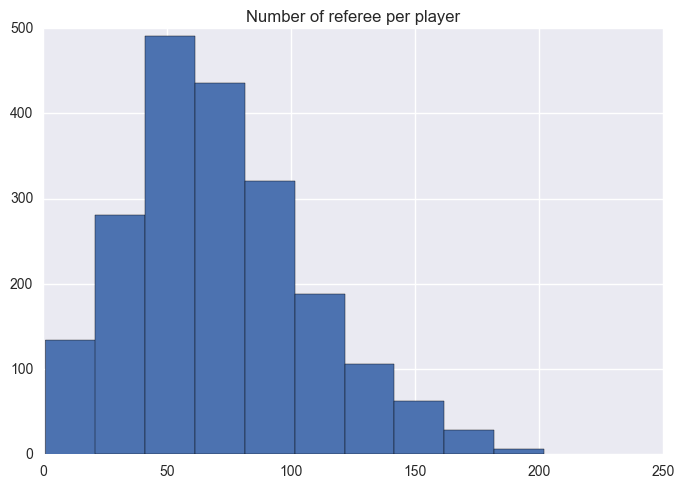

In [11]:
referee_per_player.hist()
plt.title('Number of referee per player')

One issue that might arise is for player having played with only a few referee. Let arbitrarly check for player have played with less than 5 different referees

In [12]:
(referee_per_player < 5).sum()

39

Let see the full data for these players

In [13]:
player_low_n_referees = df.set_index('playerShort')[referee_per_player < 5]
player_low_referee_ratio = player_low_n_referees['skintone'].isnull().mean()

print("P(no skintone | player has less 5 different referees) = {:0.1f}%".format(player_low_referee_ratio * 100))

P(no skintone | player has less 5 different referees) = 79.7%


/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


As we can see, we don't have skintone information for roughly 80% of the players that have less than 5 different referees. This means that it might be hard to predict the skintone for these players.

The situation might be very significant for player having only one referee linked to it.

In [14]:
player_one_referee = df.set_index('playerShort')[referee_per_player == 1]
player_one_referee_ratio = player_one_referee['skintone'].isnull().mean()

print("P(no skintone information | player has only one referee linked to him) = {:0.1f}%".format(player_one_referee_ratio*100))

P(no skintone information | player has only one referee linked to him) = 77.8%


/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


For these players, it might be harder to infer skintone.

### Numerize categories
Some field are categories but with a string representation. This breaks the random forest algorithm. In this part, we categorize the field as numeric value. 

** Remark **: Using numeric field has the issue of being ordered (where the categories aren't ordered). But, one alternative is to use dummy features. At this part of the process, dummies features would add a lot of explanatory variable. Therefore, we don't create dummy features yet.

In [15]:
LABEL_FIELDS = ['club', 'leagueCountry', 'position', 'Alpha_3']
UNKNOWN_LABEL = 'MISSING'

label_encoders = {}

from sklearn.preprocessing import LabelEncoder

df_categorized = df.copy()

for label in LABEL_FIELDS:
    encoder = LabelEncoder()
    values = df_categorized[label].fillna(UNKNOWN_LABEL, inplace=False)
    encoder.fit(values)
    transformed = encoder.transform(values)
    df_categorized[label] = transformed
    
    label_encoders[label] = encoder
    
    
# Special case for the skintone where we need to keep NaN values
encoder = LabelEncoder()
skintone = df_categorized['skintone']
skintone = skintone[skintone.notnull()]
encoder.fit(skintone)
df_categorized.loc[skintone.index, 'skintone'] = encoder.transform(skintone)
label_encoders['skintone'] = encoder

df_categorized.head(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone
0,lucas-wilchez,Lucas Wilchez,82,3,31.08.1983,177.0,72.0,0,1,0,...,1,1,60,0.326391,712.0,0.000564,0.396000,750.0,0.002696,3.0
1,john-utaka,John Utaka,62,1,08.01.1982,179.0,82.0,12,1,0,...,2,2,159,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,6.0
2,abdon-prats,Abdón Prats,73,3,17.12.1992,181.0,79.0,9,1,0,...,3,3,47,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
3,pablo-mari,Pablo Marí,73,3,31.08.1993,191.0,87.0,1,1,1,...,3,3,47,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
4,ruben-pena,Rubén Peña,81,3,18.07.1991,172.0,70.0,11,1,1,...,3,3,47,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
5,aaron-hughes,Aaron Hughes,42,0,08.11.1979,182.0,71.0,1,1,0,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.0
6,aleksandar-kolarov,Aleksandar Kolarov,59,0,10.11.1985,187.0,80.0,6,1,1,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.0
7,alexander-tettey,Alexander Tettey,65,0,04.04.1986,180.0,68.0,4,1,0,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,8.0
8,anders-lindegaard,Anders Lindegaard,60,0,13.04.1984,193.0,80.0,5,1,0,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,2.0
9,andreas-beck,Andreas Beck,2,2,13.03.1987,180.0,70.0,10,1,1,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0


# Predicting
This part focuses on predicting the `skintone`.

## Baseline
First, let try to do a naive classification with the metric:
$$
cost(p) = \sum_{a \in A(p)} IAT(a)(\text{Yellow}(p, a) + 3\text{Reds}(p,a)),
$$
where $IAT(a)$ is the IAT of the referee $a$, Yellow$(p,a)$ is the number of yellow cards given by $a$ to player $p$, and reds is the number of red cards (similarly than for the yellow).

We slighlty count that reds are more importants then yellows. Also, note that with this metric the red cards reveived by successive yellow cards are counted more than red cards given directly.

In [16]:
with pd.option_context('display.max_columns', 100):
    print(df_categorized.head(5))

     playerShort         player  club  leagueCountry    birthday  height  \
0  lucas-wilchez  Lucas Wilchez    82              3  31.08.1983   177.0   
1     john-utaka     John Utaka    62              1  08.01.1982   179.0   
2    abdon-prats    Abdón Prats    73              3  17.12.1992   181.0   
3     pablo-mari     Pablo Marí    73              3  31.08.1993   191.0   
4     ruben-pena     Rubén Peña    81              3  18.07.1991   172.0   

   weight  position  games  victories  ties  defeats  goals  yellowCards  \
0    72.0         0      1          0     0        1      0            0   
1    82.0        12      1          0     0        1      0            1   
2    79.0         9      1          0     1        0      0            1   
3    87.0         1      1          1     0        0      0            0   
4    70.0        11      1          1     0        0      0            0   

   yellowReds  redCards    photoID  rater1  rater2  refNum  refCountry  \
0           

In [17]:
df_subset = df_categorized[['playerShort', 'club', 'leagueCountry', 'position','games', 'yellowCards', 'redCards', 'meanIAT', 'skintone']].copy()

for f in ['meanIAT', 'yellowCards', 'redCards']:
    df_subset[f].fillna(0, inplace=True)

df_subset["cost"] = df_subset['meanIAT']*(df_subset['yellowCards'] + 3*df_subset['redCards'])

In [18]:
def check_field_uniqueness_per_player(df, field):
    """
    Check if the field is unique on a user basis
    Example:
      - Player one: [1,1,1,1]  -> Unique 
      - Player two: [1,1,1,2]  -> Non-unique
      - Player three: [2,2,2]  -> Unique (even if not the same as player one)

    Return if uniqueness holds for every player.
    """
    fields = list(set(['playerShort', field]))
    number_different_value_per_player = df[fields].groupby('playerShort')[field].nunique()
        
    return not any(number_different_value_per_player > 1)

non_unique_fields = []
for f in ['club', 'leagueCountry', 'position', 'skintone']:
    if not check_field_uniqueness_per_player(df_subset, f):
        non_unique_fields.append(f)
        
if len(non_unique_fields) > 0:
    print("Non-unique fields: {}".format(non_unique_fields))
else:
    print("All tested fields are unique for a player")


All tested fields are unique for a player


As we can see, each tested field is unique per player. This means that the data is quite clean (there is no case where the player-specific data is different between two player-referee dyad). Thus, for these fields, we can take an element of the grouped list as aggregator function.

In [19]:
def pick_first(elements):
    """
    Aggregator for fields where each element are the same
    """
    return elements.iloc[0]

In [20]:
df_grouped = df_subset.groupby('playerShort')

df_final = df_grouped.agg({
        'club': pick_first,
        'leagueCountry': pick_first,
        'position': pick_first,
        'cost': 'sum',
        'skintone': pick_first
    })


df_final.head(10)

,skintone,club,position,leagueCountry,cost
playerShort,,,,,
aaron-hughes,1.0,42,1,0,6.420221
aaron-hunt,1.0,110,0,2,15.384280
aaron-lennon,2.0,100,11,0,3.651979
aaron-ramsey,0.0,8,3,0,11.466394
abdelhamid-el-kaoutari,2.0,62,1,1,4.685575
abdon-prats,NaN,73,9,3,2.219362
abdou-dampha,NaN,5,0,1,3.107747
abdou-traore_2,6.0,44,11,1,3.708738
abdoul-camara,NaN,40,8,1,0.979174


Preparing to deal with null values

In [21]:
for c in df_final.columns:
    if any(df_final[c].isnull()):
        print("Column {} has missing entries".format(c))

Column skintone has missing entries


### Training

In [25]:
def split_training_predicting(df, y_label):
    """
    Given a y_label, return the training set (where y_label != NaN), and the predict set
    (where y_label == NaN).
    """
    x_predict = df[df[y_label].isnull()].drop(y_label, 1)
    
    training = df[df[y_label].notnull()]
    y_training = training[y_label]
    x_training = training.drop(y_label, 1)
    
    return (x_training, y_training, x_predict)

(x_training, y_training, x_predict) = split_training_predicting(df_final, 'skintone')

number_of_estimators = list(range(5,100,5))
max_features = list(range(1,df_final.shape[1]+1))

print(max_features)

params = {
    'n_estimators': number_of_estimators,
    'max_features': max_features,
}

#from sklearn.ensemble import RandomForestClassifier
#from sklearn.grid_search import GridSearchCV

#estimator = RandomForestClassifier(n_jobs=-1)
#gscv = GridSearchCV(estimator, params, cv=10)
#gscv.fit(x_training, list(y_training))

[1, 2, 3, 4, 5]


In [ ]:
df_final.shape